In [1]:
# import necessary libraries 
import numpy as np
import seaborn as sns

import torch
import gym

from matplotlib import pyplot as plt
from random import shuffle
from collections import deque
from variables import *

from IPython.display import YouTubeVideo
from dist_dqn import dist_dqn
from auxiliary import preproc_state, get_dist_plot
from trainer import trainer, lossfn, get_action_dqn, get_target_dist

import imageio

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


## TODO: Issues & Improvements:

- Observed reward reversed (Done).
- Include ignore warnings (Done). 
- Freeway needs to be reset (Done). 
- Maybe include more images for clarification (Done).
- Training to function. (Done)
- Remove or improve bonus question. (Done)
- Apostrophes. (Done)
- Include mathematical details. (Done)
- Reorganize folder. (Done)
- Clean code and remove redundancies. (Done)
- Prettify plots. (Done)
- Variable renaming for clarity. (Done)
- Improve references. (Done) 
- Include Questions. (Done)
- GitHub.
- Check function descriptions. 

# Distributional Reinforcement Learning 


## The Expectation Revisited

We will very briefly discuss how to compute the expectation. Recall the the expectation is essentially the weighted average of each of the values in the sample space. 

We can compute it as follows:

In [2]:
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


As more succinct way, however, is to compute the expected value as the dot product of the possible outcomes and their corresponding probabilities. We can use the ``@`` operator. 

In [3]:
expected_value = probs @ outcomes
print(expected_value)

18.4


In distributional RL, instead of talking about the sample space (which can be infinite), we make use of the set of *possible* outcomes, called the **support**. The difference seems minor, but it is important to mention. 

## The Bellman Equation Revisited

As we have seen throughout the week, most reinforcement learning algorithms determine the quality of an action through the *Bellman* equation:

$$\large Q(s_{t},a_{t}) \leftarrow \mathbb{E}[R(s_{t},a)] + \gamma \mathbb{E}[Q(S_{t+1}, A_{t+1})],$$

where $Q(s_{t},a_{t})$ denotes the quality of the action given the current state, $\gamma$ the discount factor and $Q(S_{t+1}, A_{t+1})$ the quality of the state and action at the next time step. 

## The *Distributional* Bellman Equation 

A key difference between "regular" reinforcement learning and distributional reinforcement learning (DRL) is that in DRL, we do not "collapse" (which we call a *degenerate* distribution) into a single value, the expectation. 

As such, in distributional RL, we are interested in learning the *entire* value distributions. We can formalise it as follows:

$$\large Z(s_{t},a_{t}) \leftarrow R(s_{t},a) + \gamma Z(S_{t+1}, A_{t+1}),$$

where $Z$ takes the place of $Q$. Note that it is just notational convention to use $Z$ instead of $Q$. We use $Z$ to make clear that we are talking about a *distribution* rather than a single Q-value.

## Updating the Distributional Bellman Equation 

An essential part of distributional reinforcement learning deals with *updating* the distributional Bellman equation. In this section, we will discuss and implement an updating procedure for $Z$. 

Important to note here is that we will use Bayesian updating, meaning that we update a prior based on information we encounter from the environment (i.e. the rewards we get).

To make things a bit more concrete, we will implement an updating procedure with a specific setting in mind. Here we will start with the game of Freeway. Freeway is an Atari game where the goal is for a chicken to cross the a highway without being hit by a car. 

The reward structure is as follows:

- We received +10 reward if the chicken successfully crosses the highway.
- If the game is lost (the chicken does not manage to cross the street within a certain amount of time), we get a reward of -10. 
- At all non-terminal steps, we get a reward of -1. We do this to make sure that the agent *acts* and does not wait for too long. 

Moreover, we have 3 possible actions:

- NOOP. No operation, do nothing.
- DOWN. Go down.
- UP. Go up. 

By means of a short illustration, consider the following clip:

<img src="img/freeway.gif" width="750" align="center">

### Prior Distribution 

We update the distribution in accordance with a Bayesian updating rule. In other words, we start with a prior and gradually update it to a posterior (target) distribution. The question is the how to do this. Here we will follow the approach of Bellemare et.al. (2017) for approximate distributional learning which they formulate in terms of the **Categorical Algorithm**.

First of all, it is important to cut off the reward distribution. If we would not do this, we would end up with an infinite range. As such, our distribution will be parameterized by two values, $V_{\text{MIN}}$ and $V_{\text{MAX}}$.

Since the most negative reward we can receive in Freeway is -10 and the most positive reward is +10, we will fix these two values as the limits of the reward distribution. 

In [4]:
vmin,vmax = -10.,10.

Another key concept is the support. The support is set of all possible outcomes we can obtain. In our case, this can be -10, +10, but also -1. Because of the probabilistic nature, however, we may also obtain reward values of, say, -4.2 or 5.

For computational purposes, we work with *discrete* distributions. As such, all reward values need to be *binned* before we can actually work with them. Here we choose a prior distribution 51 possible outcomes. These 51 values are the **support** of our distribution. 

In [5]:
nsup=51  # number of items in the support 
support = np.linspace(vmin,vmax,nsup) 
print(support)

[-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ]


**Quick sidenote:** We could have chosen a different support number. Here we selected 51, because it the difference between the bins is 0.4. 

Let us now construct the actual prior distribution. Note that because we do not know anything about the reward structure of the environment, we assume that each outcome is equally likely. 

In [6]:
probabilities = np.ones(nsup)
prior = probabilities / probabilities.sum()
prior

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

We can visualize our distribution. 

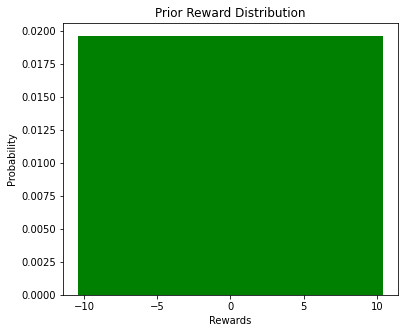

In [7]:
plt.rcParams['figure.figsize'] = (6,5)
plt.bar(support,prior, color = 'green')
plt.ylabel('Probability')
plt.title('Prior Reward Distribution')
plt.xlabel('Rewards');

Note that we have two vectors: the ``support`` vector (corresponds to all events with non-zero probability) and the ``probabilities`` vector which holds the probabilities for the values in the support vector. 

### Posterior Distribution: Locating the Reward Value

We will now gradually implement a function that does this. The goal of the function is to iteratively update the prior distribution in order to obtain a posterior distribution, $Z$. 

To reiterate, the Q-function we want to update is

$$\large Z(s_{t},a_{t}) \leftarrow R(s_{t},a) + \gamma Z(S_{t+1}, A_{t+1}).$$

Let us first set the parameters of the model. Here assume a $\gamma$ of 0.8.

In [8]:
 gamma = 0.8
Z = prior    # rename prior to Z
observed_reward = 5

Suppose that we are beginning updating the value distribution for our action $a_{\text{up}}$. Also assume that we have a reward of $5$.

In that case, our belief in that $5$ being representative of the actual reward structure in the environment is being *reinforced*. This means that all other values are *less likely* and that the observing a $5$ is *more likely*. 

A key insight is that we *move probability mass from the other points to the centre of mass* (in this case 5).

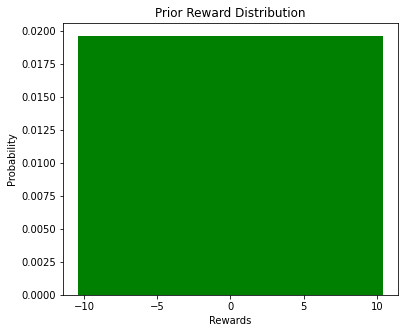

In [9]:
# Assume that for a given action, we get a reward of 5
plt.bar(support,Z, color = 'green')
plt.ylabel('Probability')
plt.title('Prior Reward Distribution')
plt.xlabel('Rewards');

The question is now *how* to update this particular distribution. More specifically, how do we *algorithmically* update the prior. Even more concrete - *where* do put that value on the support vector? 

In [10]:
print(support)

[-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ]


First of all, we observed that the spacing between the support values is 0.4. We do not need to observe this, but can also derive it using the following formula, which computes the closest support element:

$$\large \Delta z = \frac{V_{MAX} - V_{MIN}}{N-1}, $$

where $\Delta z $ denotes the closeness between the elements in the support vector and $N$ the number of elements in the support vector. 

**Question 1**:  Verify that the space between each element is indeed 0.4 by implementing the equation above. Make sure that the variable name is ``dz``.

In [11]:
# Compute the projection of the update onto the support vector
# d(elta)z is the closest support element 
# YOUR CODE HERE
dz = (vmax-vmin)/(nsup-1.)
print(dz)

0.4


As a next step, we want to pinpoint exactly where the value $5$ falls on the support vector. It is highly likely that the observed reward will not fall exactly on one of the elements in the support vector. As such, we need to find the *index* value of the *closest* support element, which we we call $b_{j}$.

We can use the following formula to find the closest support element:

$$\large b_{j} = \frac{r-V_{MIN}}{\Delta z},$$

where $r$ denotes the observed reward. 

Note that $b_{j}$ can take on any value in the support vector. In this case, $b_{j} \in [0, N - 1].$

**Question 2:** Implement the equation above. Make sure that $b_{i} \in \mathbb{Z}$ (i.e. make sure that $b_{i}$ is an integer value). Make sure to name the variable ``bj``.

In [12]:
# compute bj, the index value of the support vector 
# YOUR CODE HERE

bj = np.round((observed_reward-vmin)/dz) 
bj = int(bj)

Evaluate the value of ``bj``. Does it correspond to the location of the reward ``5`` in the plots above?

In [13]:
print(bj)

38


### Posterior Distribution: Updating the Probability Vectors

Because it is convenient to keep a copy of the original distribution, create a copy of the original ``probabilities`` vector and call it ``posterior``.

In [14]:
posterior = prior.copy()
posterior

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

Every time the agent encounters a reward we update the posterior distribution. One way to think of this is that probability mass is shifted from the left and right sides of the reward value to the value of the observed reward. In other words, probability mass gets *redistributed* towards the centre of mass. 

As illustrated below, our goal here is to update the uniform distribution by gradually moving mass to the centre of mass, both from the left side as from the right side. 

![alt text](img/normal_uniform.jpg "Title")


By now it should become clear why computing the index of the support vector was so important: we need it to determine *where* on the probabilities vector to move the mass to. 

As such, the support act as our sample space and the probabilities vector to the probabilities on that sample space. 

In the context of reinforcement learning, **updating the target distributions** refers to the agent making an update to the empirical reward distribution each time it receives a reward. One way to think of this is that probability mass is shifted from the left and right sides of the reward value to the value of the observed reward. 

Now, for each point in the probabilities vector (remember, there are 51 items in that vector), we gradually want to update the values by stealing some mass from its immediate neighbor. 

To make things a bit more precise, we will follow a two-step procedure:

1. We will steal mass from the neighbors left of $b_{j}$.
2. We will steal mass from the neighbors right of $b_{j}$.

Let us consider a couple of cases of "mass-stealing" for the neighbors **left** of $b_{j}$.

$$ \large m^{i}_{l} \leftarrow m^{i}_{l} + \gamma^{j} m^{i-1}_{l},$$

where $m_{l}^{i}$ denotes the probability mass of the value we want to update, $\gamma^{j} m^{i-1}_{l}$ how much we steal from its neighbor on the left and $\gamma^{j}$ denotes the discount factor with an index $j$ (this tells us how far we are removed from the centre of mass - the further away from $b_{j}$ the fewer mass is being stolen).


**Question 3:** Consider for instance the following loop and observe how the value changes for different values of ``gamma``. How does the output changes for ``gamma = 1``, ``gamma = 0.8`` and ``gamma = 0.4``? And what happens as ``j`` increases? 

In [15]:
gamma = 0.4

for j in range(1, 5):
    print(f'j: {j}. Value for second term: {np.round(np.power(gamma, j), 2)}.')

j: 1. Value for second term: 0.4.
j: 2. Value for second term: 0.16.
j: 3. Value for second term: 0.06.
j: 4. Value for second term: 0.03.


The values around the observed reward value $r$ are more likely than values further down the line (e.g. if we observe 5, than 4 is more likely to be observed than -10). As such, we want to update each of the values in the probabilities (i.e. posterior) vector.

Important to note here is *each* value of the distributions is being updated. As can be seen in the formula, the update always contain the value of $m^{i}_{l}$ itself plus a discounted update term, $\gamma^{j} m^{i-1}_{l}$. 

Let us look at a couple of examples. First, let us look at what an update of the value for $r=5$, which, as we computed, is located at $b_{j} = 38$, would look like. 

In [16]:
gamma = 0.8
j = 1       # j indicates how far we are removed from the centre of mass bj
updated_val = posterior[38] + ((gamma**j) * posterior[38-1])
print(updated_val)

0.03529411764705882


As can be seen, the new *probability value* at index *38* is now ~0.035 instead of ~0.020. 

Let us consider the next value. 

In [17]:
j = 2       # j indicates how far we are removed from the centre of mass bj
updated_val = posterior[37] + ((gamma**j) * posterior[37-1])
print(updated_val)

0.03215686274509804


Note that the new value is ~0.032. As can be seem, the index parameter *j* reduces the amount of mass shifted from one point to the next. 

**Question 4:** Now it is your turn. Write a for loop that gradually updates each of the values on the left side of the centre of mass at $b_{j}$. Make sure to update the values in the ``posterior`` vector.

In [18]:
# redistribute probability mass for each of the values on the left side to the observed reward value
# YOUR CODE HERE
posterior = prior.copy()
j = 1

for i in range(bj,1,-1):
    posterior[i] += np.power(gamma,j) * posterior[i-1]
    j += 1

Verify the output. You should observe a step-pattern on the left side of $b_{j} = 38$. As you can imagine, we also want to update the points on the right of the centre of mass. 

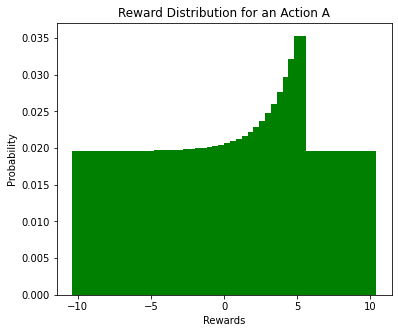

In [19]:
plt.bar(support,posterior, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

**Question 5:** Update the points on the right side using the following update rule:

$$ \large m^{i}_{r} \leftarrow m^{i}_{r} + \gamma^{j} m^{r+1}_{r},$$

where $m_{r}^{i}$ denotes any point on the right of $b_{j}$.

In [20]:
# redistribute probability mass for each of the values on the left side to the observed reward value
# YOUR CODE HERE
j = 1
for i in range(bj,nsup-1,1):
    posterior[i] += np.power(gamma,j) * posterior[i+1]
    j += 1

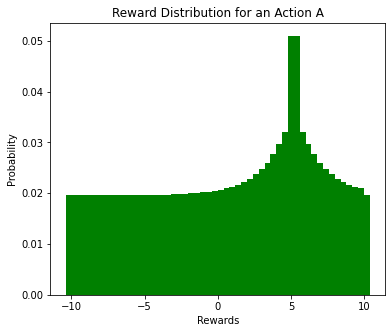

In [21]:
plt.bar(support,posterior, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

Because we are dealing with a probability distribution, check if the sum still equals 1. If this is not the case, normalize the output. 

In [22]:
# YOUR CODE HERE
posterior /= posterior.sum() 
sum(posterior)

1.0

Run the code below. You should see a mode around the reward value $5$, with a step pattern on both sides of this value. 

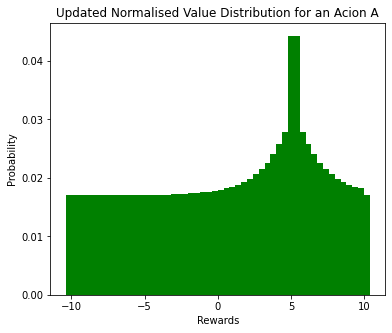

In [23]:
plt.bar(support,posterior, color = 'green')
plt.title('Updated Normalised Value Distribution for an Acion A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

We have now created all the necessary building blocks to build an updater function. 

**Question 6:** Combine all the individual pieces of code into a function that returns the updated posterior. Please do not change the input parameters - we will need this function later on. Moreover, make sure that the function return the *entire* updated distribution.

In [24]:
def update_dist(observed_reward, support, probabilities, vmin, vmax, gamma=0.8):
    """Function that updates the input distribution in accordance with observed reward.

    Args:
        observed_reward (int): Reward observed after taking some action.
        support (torch.Tensor): Support vector.
        probabilities (torch.Tensor): Probability vector. 
        vmin (float): Lower bound of the support.
        vmax (float): Upper bound of the support.
        gamma (float): Discount factor. 

    Returns:
        posterior.
    """
    # YOUR CODE HERE
    nsup = probabilities.shape[0]
    dz = (vmax-vmin)/(nsup-1.)
    bj = int(np.round((observed_reward-vmin)/dz))
    #bj = int(np.clip(bj,0,nsup-1)) 
    posterior = probabilities.copy()
    j = 1
    for i in range(bj,1,-1): 
        posterior[i] += np.power(gamma,j) * posterior[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): 
        posterior[i] += np.power(gamma,j) * posterior[i+1]
        j += 1
    posterior /= posterior.sum() 
    return posterior

Run the code below and evaluate the output. Does it cluster around the observed reward value?

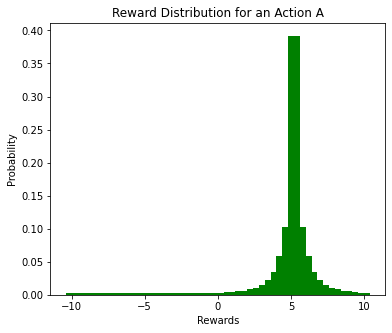

In [25]:
observed_reward = 5    # set hypothetical reward
number_of_obs = 10     # set the number of observations
Z = prior              # initialise prior

for i in range(number_of_obs):
    Z = update_dist(observed_reward,support,Z,vmin,vmax,gamma=0.8)

plt.bar(support,Z, color = 'green')
plt.title('Reward Distribution for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

Note that the more often a certain reward is received by the agent, the higher the tendency the cluster around one value (or values, as we will see in a bit). As such, the variance decreases with more observations. 

Consider the code below. We now have a more complicated reward structure. Does it cluster around the various modes?

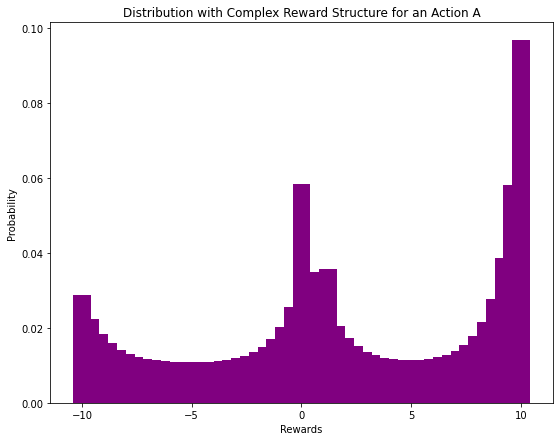

In [26]:
Z = prior
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], support, Z, vmin,vmax, gamma=0.7)

plt.figure(figsize=(9,7))
plt.bar(support, Z, color = 'purple')
plt.title('Distribution with Complex Reward Structure for an Action A')
plt.ylabel('Probability')
plt.xlabel('Rewards');

As can be seen, the reward structure is more complicated in this scenario. This can be hugely beneficial in the context of reinforcement learning, because the agent can now make more nuanced decision. 

In this specific case, sometimes the action gives a reward of 0, most of the times a reward of 10, but a reward of -10 is also quite likely. This cannot be modeled by a "classical reinforcement" learner. For instance, if we just take the mean, we would think that this action yields a much lower reward.

In [27]:
np.mean(ob_rewards)

3.1

Furthermore, incorporated within this distribution is a risk-reward trade-off. Sometimes taking this action may yield +10, but it may sometimes also lead to a catastrophic failure (i.e. if we get -10). The "classical" agent may not infer this from a simple expected reward of 3.1. 

## Selecting an Action: Collapse of the Reward Distribution

We have been implementing an updating procedure for one single action. Let us now consider the consider a hypothetical scenario where we play a game with 3 actions. The reward structures are defined as follows:

In [28]:
ob_rewards1 = [10,10,10,0,1,0,-10,-10,10,10]
ob_rewards2 = [5,5,5,1,5,4,5,5,5,5]
ob_rewards3 = [-4,-3,-4,0,-2,-4,-4,-3,-5,-5]

For each of the actions, we defined a prior. As before, our prior will be a simple, uniform distribution with a support of 51. 

In [29]:
probabilities = np.ones(51)
prior = probabilities / probabilities.sum()
prior

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

We can now define three priors over the actions spaces, $Z_{1}$, $Z_{2}$ and $Z_{3}$ - three distributions we need to update. 

In [30]:
Z1, Z2, Z3 = prior, prior, prior

As before, we can loop over the update function. Now, however, we do this for each of the three actions.

In [31]:
for i in range(len(ob_rewards1)):
    Z1 = update_dist(ob_rewards1[i], support, Z1, vmin,vmax, gamma=0.7)
    Z2 = update_dist(ob_rewards2[i], support, Z2, vmin,vmax, gamma=0.7)
    Z3 = update_dist(ob_rewards3[i], support, Z3, vmin,vmax, gamma=0.7)

Let us visualize three distributions for the 3 actions.

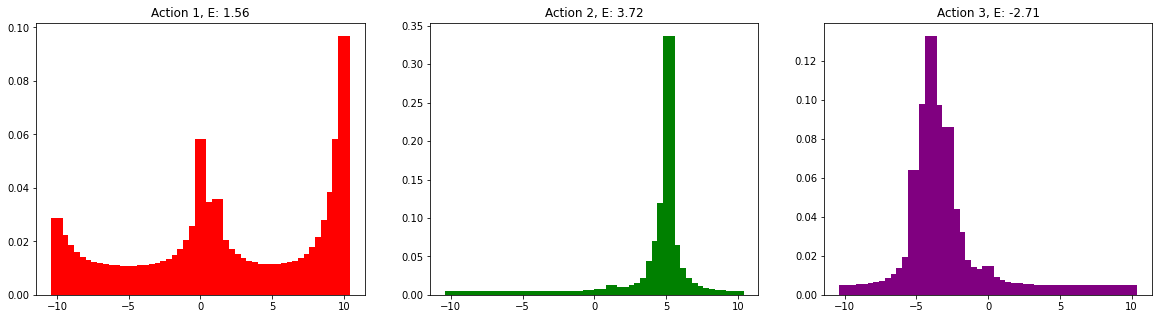

In [32]:
plt.rcParams['figure.figsize'] = (20,5)

#The below code will create two plots. The parameters that .subplot take are (row, column, no. of plots).
plt.subplot(1,3,1)
action1 = plt.bar(support, Z1, color = 'red')
plt.title(f'Action 1, E: {np.round(support @ np.array(Z1), 2)}')
plt.subplot(1,3,2)
action2 = plt.bar(support, Z2, color = 'green')
plt.title(f'Action 2, E: {np.round(support @ np.array(Z2), 2)}')
plt.subplot(1,3,3)
action3 = plt.bar(support, Z3, color = 'purple')
plt.title(f'Action 3, E: {np.round(support @ np.array(Z3), 2)}')
plt.show()

As can be seen, we have 3 distributions. Each of these corresponds to the distribution of the reward structure. In other words, based on $n$ observations, taking the action $A_{1}$ yields $Z_{1}$, $A_{2}$ yields $Z_{2}$ and $A_{3}$ yields $Z_{3}$. 

Because we are working with distributions over the action space, let us combine $Z_{1}$, $Z_{2}$ and $Z_{3}$ into a 3X51 array. 

In [33]:
dist = np.array([Z1, Z2, Z3])
dist.shape

(3, 51)

Selecting an action $a'$ from the set of possible actions on the next step can be modeled as follows:

$$\large \underset{a' \in A_{t+1}}{\text{argmax}} \mathbb{ E } [Z(S_{t+1})].$$

Thus, we select the action that maximizes the expected value. 

**Question 7:** Write a piece of code that selects, from these three actions, the best one. 

Hint: As discussed in the beginning, the expectation can be computed as the dot product of the support vector and its corresponding probabilities ``expected_value = probs @ outcomes``.

In [34]:
def get_action(dist,support):
    # YOUR CODE HERE
    """This function returns an integer action in [0,1,2].
    
    Args: 
        dist (np.array): Input is a Ax51 array.
        support (np.array): Support vector.

    Returns:
        actions (int): vector of integers in {0,1,2}, dimension dist.shape[0] 
    """
    
    actions = []

    for i in range(dist.shape[0]):
        expectation = support @ dist[i]
        actions.append(expectation)                  # append action
        
    action = int(np.argmax(actions))                 # select action with highest reward
    
    return action


In [35]:
get_action(dist,support)

1

As can be seen, based on the distributions, we should select action 1. 

## Distributional Deep Reinforcement Learning

We will now implement an actual game, Atari Freeway. As said before, the goal of this game is the run across a highway and gain as many points as possible. If you get hit by a car, you are being pushed back. If you reach the other side, you will get a reward of 1. Watch a couple of minutes of the clip below for a visual demonstration. 

<img src="img/freeway.gif" width="750" align="center">

We will now have a look at a Distributional DQN implementation of the Atari Freeway Game. We will start with a couple of functions. Some are given, some require you to complete a line of code. 

To simulate the environment, we will make use of OpenAI ``gym``. Have a look at the actions. 

In [36]:
env = gym.make('Freeway-ram-v0') 
aspace = 3                          # action space size
env.env.get_action_meanings()    

['NOOP', 'UP', 'DOWN']

Let us now set the other hyperparameters.

In [37]:
vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
gamma = 0.1
episodes = 3000

Let us now initialise the network parameters. Note that we did not include the network in this notebook. If you are interested you can check out the network in the ``dist_dqn.py``-file.

**Question 8 (Bonus):** Run the trainer. 

We can now train the model by calling the trainer function. This function returns $\theta$, ``theta``, the parameters of the neural network and the ``losses``, which are the losses over time. The exact workings of this function is beyond the scope of this session, but you are encouraged to check out the code yourself (to be found in the ``trainer.py`` file).

In [38]:
# start training
theta, losses = trainer(env, aspace, nsup, vmin, vmax, gamma, episodes)

Episodes completed: 0.
Episodes completed: 200.
Episodes completed: 400.
Episodes completed: 600.
Episodes completed: 800.
Episodes completed: 1000.
Episodes completed: 1200.
Episodes completed: 1400.
Episodes completed: 1600.
10 games won!
Episodes completed: 1800.
20 games won!
Episodes completed: 2000.
30 games won!
Episodes completed: 2200.
40 games won!
Episodes completed: 2400.
45 games won!
Episodes completed: 2600.
60 games won!
Episodes completed: 2800.
65 games won!
tensor([-0.0799,  0.0317,  0.0495,  ..., -0.0603, -0.0457, -0.0242],
       requires_grad=True)


Let us now visualize the loss over time. 

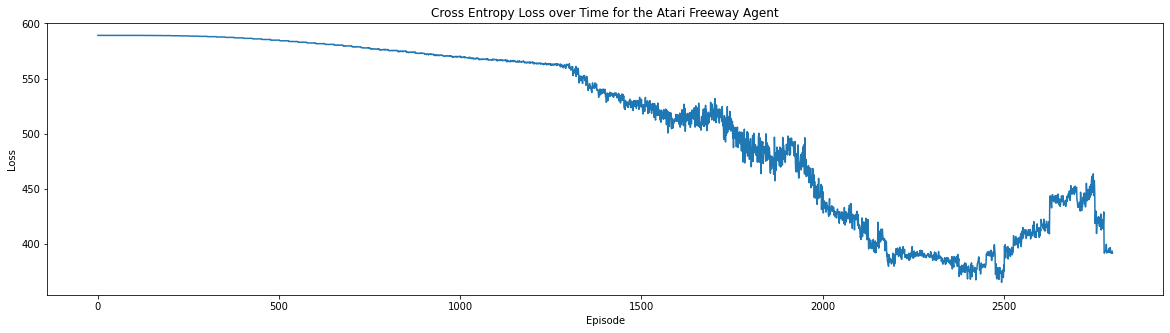

In [39]:
plt.plot(losses) 
plt.title('Cross Entropy Loss over Time for the Atari Freeway Agent')
plt.ylabel('Loss')
plt.xlabel('Episode');

We can also observe how the agent is doing. Run the cell below to generate a visualization of the DQN agent playing a game of Atari Freeway.

In [ ]:
# create empty list, to be populated by frames
clip = []

# reset the game
state = preproc_state(env.reset())
for i in range(1000):
    if i % 100 == 0:
        print(f"Rendering: {(i/1000)*100}% complete...")
    
    # make a prediction for a given state
    pred = dist_dqn(state,theta,3)
    # get the image
    image = get_dist_plot(env,pred,support,shape=(210,160,3))
    #pred = pred.detach.numpy()
    # select best action
    action = get_action_dqn(pred.unsqueeze(dim=0).detach().numpy(),support).item()
    # get state, reward and information
    s,r,d,j = env.step(action)
    # preprocess new state
    state = preproc_state(s)
    # append individual frames
    clip.append(image)
    
print('Rendering complete! Converting to mp4...')

# write to mp4
imageio.mimwrite('img/AtariHighway-v2.mp4', clip, fps = 20)

print('Done!')

Rendering: 0.0% complete...
Rendering: 10.0% complete...


**Question 9 (Bonus):** Consider the clip below. Explain the behaviour of the agent using the distribution on the right hand side of the game. 

In [ ]:
%%HTML
<video width='600' height='500' controls>
  <source src='img/AtariHighway-v2.mp4' type='video/mp4'>
</video>

# References 

- [A Distributional Perspective on Reinforcement Learning, Bellemare et.al. (2017)] (https://arxiv.org/pdf/1707.06887.pdf)
- Deep Reinforcement Learning in Action, Zai & Brown 2020.
- [Deep Reinforcement Learning in Action, Zai & Brown, Github Repository](https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction)
- [Distributional Reinforcement Learning, Bellemare, Dabney and Rowland (2022, draft)](https://www.distributional-rl.org)